# Brain Tumor Detection; Comparison of Transfer Learning models with VGG16 and Resnet 50

This Jupyter Notebook demonstrates building a brain tumor detection model using the VGG16 and Resnet 50 pre-trained convolutional neural network (CNN) for transfer learning. Transfer learning leverages the knowledge learned by models on a massive image dataset (ImageNet) to accelerate your brain tumor detection model's training and potentially improve its performance.

**Steps:**

1. **Import Necessary Libraries**
2. **Load and Preprocess Brain Tumor Dataset**
   - Download and prepare the brain tumor dataset
   - Explore the dataset's content and structure (number of images, classes, etc.)
   - Preprocess images: resizing, normalization, data augmentation (optional)
3. **Prepare Dataloader**
4. **Load the Model**
   - Use the deep learning library FAST.AI to load the model pre-trained on ImageNet.
   - Freeze the convolutional base layers of models to retain their learned features.
   - Add custom classification layers suitable for brain tumor detection.
5. **Compile and Train the Model**
  - Define loss function (e.g., binary cross-entropy for binary classification)
   - Choose an optimizer (e.g., Adam)
   - Specify metrics (e.g., accuracy)
   - Train the model on the preprocessed brain tumor dataset
   - Monitor training progress (loss, accuracy) using visualization tools
   - Consider using techniques like early stopping or learning rate scheduling to optimize training
6. **Evaluate the Model**
   - Evaluate the model's performance on a separate test dataset that wasn't used for training.
   - Calculate metrics like accuracy, precision, recall, F1-score, and confusion matrix.
7. **Visualize Results**
   - Visualize intermediate activations using techniques like Grad-CAM to understand which image regions the model focuses on for classification.
   - Generate predictions on new brain tumor images.

**Additional Considerations:**

- Experiment with hyperparameter tuning (e.g., learning rate, batch size) to improve model performance.
- Consider using data augmentation techniques (e.g., random rotations, flips) to artificially increase the dataset size and improve model generalization.


This project can contribute to the advancement of medical image analysis and potentially aid in early diagnosis of brain tumors.


# Import Necessary Libraries

In [1]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 46.3 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler
from torchmetrics import Accuracy, Precision, Recall, F1Score
import matplotlib.pyplot as plt
%matplotlib inline

import time
import os
import copy

import shutil
import warnings
import random
import numpy as np

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

warnings.filterwarnings('ignore')

# Load and Preprocess Brain Tumor Images

In [4]:
from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
 83% 72.0M/86.8M [00:00<00:00, 196MB/s]
100% 86.8M/86.8M [00:00<00:00, 205MB/s]


In [ ]:
! unzip /content/brain-tumor-classification-mri.zip

In [7]:
# Define source directories
training_dir = '/content/Testing'
testing_dir = '/content/Training'

# Define target directories
target_images_train_dir = 'Images/train'
target_images_valid_dir = 'Images/valid'
target_labels_train_dir = 'Labels/train'
target_labels_valid_dir = 'Labels/valid'

# Create target directories if they do not exist
os.makedirs(target_images_train_dir, exist_ok=True)
os.makedirs(target_images_valid_dir, exist_ok=True)
os.makedirs(target_labels_train_dir, exist_ok=True)
os.makedirs(target_labels_valid_dir, exist_ok=True)

# Function to copy files
def copy_files(src_dir, target_dir):
    for tumor_type in os.listdir(src_dir):
        tumor_src_dir = os.path.join(src_dir, tumor_type)
        tumor_target_dir = os.path.join(target_dir, tumor_type)
        os.makedirs(tumor_target_dir, exist_ok=True)

        for filename in os.listdir(tumor_src_dir):
            src_file = os.path.join(tumor_src_dir, filename)
            target_file = os.path.join(tumor_target_dir, filename)
            shutil.copyfile(src_file, target_file)

# Copy training images
copy_files(training_dir, target_images_train_dir)
# Copy testing images as validation images
copy_files(testing_dir, target_images_valid_dir)

# Create empty label directories as YOLO requires label files for each image
def create_empty_labels(image_dir, label_dir):
    for tumor_type in os.listdir(image_dir):
        tumor_image_dir = os.path.join(image_dir, tumor_type)
        tumor_label_dir = os.path.join(label_dir, tumor_type)
        os.makedirs(tumor_label_dir, exist_ok=True)

        for filename in os.listdir(tumor_image_dir):
            label_filename = os.path.splitext(filename)[0] + '.txt'
            label_file = os.path.join(tumor_label_dir, label_filename)
            open(label_file, 'a').close()

# Create empty labels for training and validation sets
create_empty_labels(target_images_train_dir, target_labels_train_dir)
create_empty_labels(target_images_valid_dir, target_labels_valid_dir)

print("Dataset reorganization completed successfully.")


Dataset reorganization completed successfully.


# Prepare Dataloader

In [8]:
# Define transformations for the training and validation data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder
data_dir = '/content/Images'
image_datasets = {x: datasets.ImageFolder(root=f'{data_dir}/{x}', transform=data_transforms[x]) for x in ['train', 'valid']}

# Create DataLoader for training and validation
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes


# Load the Model

In [33]:
# Load the pre-trained VGG16 model
vgg = models.vgg16(pretrained=True)

# Load the pre-trained resnet model
resnet = models.resnet50(pretrained=True)

def modify_model(model, name):
    # Freeze all the layers
    for param in model.parameters():
        param.requires_grad = False

    if name == 'vgg':
        # Unfreeze the last two convolutional blocks (adjust as needed)
        for param in model.classifier[5].parameters():  # Module 5 for layer block 5
            param.requires_grad = True
        for param in model.classifier[6].parameters():  # Module 6 for layer block 6
            param.requires_grad = True

        # Modify the classifier to fit the number of classes
        num_classes = len(class_names)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

        # Move the model to GPU if available
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)
        # Define the learning rate scheduler
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        return model, optimizer, scheduler

    elif name == 'resnet':
        # Unfreeze the last two residual blocks (adjust as needed)
        for param in model.layer4[1].parameters():  # Module for block 2 after first conv
            param.requires_grad = True
        for param in model.layer4[2:].parameters():  # Modules for block 3 onwards
            param.requires_grad = True
        # Modify the classifier to fit the number of classes
        num_classes = len(class_names)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

        # Move the model to GPU if available
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
        # Define the learning rate scheduler
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        return model, optimizer, scheduler

# Modify the models
vgg, vgg_optimizer, vgg_scheduler = modify_model(vgg, name = 'vgg')
resnet, resnet_optimizer, resnet_scheduler = modify_model(resnet, name = 'resnet')


In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [35]:
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()

num_classes = len(class_names)
# Define the metrics
accuracy = Accuracy(num_classes = num_classes, task='multiclass').to(device)
precision = Precision(num_classes=num_classes, average='macro', task='multiclass').to(device)
recall = Recall(num_classes=num_classes, average='macro', task='multiclass').to(device)
f1_score = F1Score(num_classes=num_classes, average='macro', task='multiclass').to(device)

# Compile and train the model

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, save_filename='best_model.pth'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience = 5  # patience for early stopping

    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': [],
               'train_precision': [], 'valid_precision': [], 'train_recall': [], 'valid_recall': [], 'train_f1': [], 'valid_f1': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_precision = 0.0
            running_recall = 0.0
            running_f1 = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_precision += precision(preds, labels)
                running_recall += recall(preds, labels)
                running_f1 += f1_score(preds, labels)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_precision = running_precision / len(dataloaders[phase])
            epoch_recall = running_recall / len(dataloaders[phase])
            epoch_f1 = running_f1 / len(dataloaders[phase])

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            history[f'{phase}_precision'].append(epoch_precision.item())
            history[f'{phase}_recall'].append(epoch_recall.item())
            history[f'{phase}_f1'].append(epoch_f1.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1: {epoch_f1:.4f}')

            if phase == 'valid':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    patience = 5  # Reset patience when new best accuracy is found
                else:
                    patience -= 1

        print()

        if patience == 0:
            print(f'Early stopping triggered after epoch {epoch}.')
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Save the best model weights to a file
    torch.save(best_model_wts, save_filename)

    model.load_state_dict(best_model_wts)
    return model, history


In [37]:
# Train the vgg model
vgg_trained_model, vgg_history = train_model(vgg, criterion, vgg_optimizer, vgg_scheduler, num_epochs=25, save_filename = 'vgg_best_model.pth')

Epoch 0/24
----------
train Loss: 1.3378 Acc: 0.3325 Precision: 0.3026 Recall: 0.3414 F1: 0.2838
valid Loss: 1.3363 Acc: 0.3770 Precision: 0.4073 Recall: 0.3967 F1: 0.3237

Epoch 1/24
----------
train Loss: 1.0780 Acc: 0.5254 Precision: 0.5444 Recall: 0.5160 F1: 0.4958
valid Loss: 1.3402 Acc: 0.4470 Precision: 0.4737 Recall: 0.4768 F1: 0.4259

Epoch 2/24
----------
train Loss: 1.0064 Acc: 0.5685 Precision: 0.5684 Recall: 0.5705 F1: 0.5300
valid Loss: 1.2310 Acc: 0.5460 Precision: 0.5149 Recall: 0.5448 F1: 0.4845

Epoch 3/24
----------
train Loss: 0.9549 Acc: 0.6041 Precision: 0.5792 Recall: 0.6220 F1: 0.5733
valid Loss: 1.2438 Acc: 0.5352 Precision: 0.5170 Recall: 0.5553 F1: 0.4849

Epoch 4/24
----------
train Loss: 0.9224 Acc: 0.6218 Precision: 0.6239 Recall: 0.6316 F1: 0.6096
valid Loss: 1.1933 Acc: 0.5557 Precision: 0.5324 Recall: 0.5675 F1: 0.5073

Epoch 5/24
----------
train Loss: 0.8346 Acc: 0.6751 Precision: 0.6623 Recall: 0.6811 F1: 0.6527
valid Loss: 1.1860 Acc: 0.5655 Precisi

In [38]:
# Train the resnet model
resnet_trained_model, resnet_history = train_model(resnet, criterion, resnet_optimizer, resnet_scheduler, num_epochs=25, save_filename = 'resnet_best_model.pth')

Epoch 0/24
----------
train Loss: 1.3701 Acc: 0.3401 Precision: 0.2885 Recall: 0.3399 F1: 0.2442
valid Loss: 1.5085 Acc: 0.1502 Precision: 0.1285 Recall: 0.2522 F1: 0.0859

Epoch 1/24
----------
train Loss: 1.1752 Acc: 0.4746 Precision: 0.5164 Recall: 0.4745 F1: 0.4254
valid Loss: 1.3561 Acc: 0.3679 Precision: 0.3755 Recall: 0.4169 F1: 0.3004

Epoch 2/24
----------
train Loss: 1.0776 Acc: 0.5584 Precision: 0.6045 Recall: 0.5651 F1: 0.5180
valid Loss: 1.4190 Acc: 0.4453 Precision: 0.3912 Recall: 0.4827 F1: 0.3758

Epoch 3/24
----------
train Loss: 1.0358 Acc: 0.5508 Precision: 0.6054 Recall: 0.5428 F1: 0.5131
valid Loss: 1.3036 Acc: 0.5303 Precision: 0.4627 Recall: 0.5521 F1: 0.4493

Epoch 4/24
----------
train Loss: 1.0259 Acc: 0.5761 Precision: 0.6266 Recall: 0.5714 F1: 0.5392
valid Loss: 1.3316 Acc: 0.4808 Precision: 0.4773 Recall: 0.4961 F1: 0.4084

Epoch 5/24
----------
train Loss: 0.9581 Acc: 0.6091 Precision: 0.6837 Recall: 0.6333 F1: 0.6001
valid Loss: 1.1788 Acc: 0.5383 Precisi

# Evaluate the model

In [39]:
def evaluate_model(model, dataloaders):
    model.eval()
    running_corrects = 0

    for inputs, labels in dataloaders['valid']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / dataset_sizes['valid']
    print(f'Validation Accuracy: {acc:.4f}')




In [40]:
# Evaluate the model
evaluate_model(vgg_trained_model, dataloaders)

Validation Accuracy: 0.5794


In [41]:
# Evaluate the model
evaluate_model(resnet_trained_model, dataloaders)

Validation Accuracy: 0.6031


In [42]:
import matplotlib.pyplot as plt

def plot_training_results(history):
  """Plots training and validation results for loss, accuracy, precision, recall, and F1-score.

  Args:
      history: A dictionary containing training and validation results for each epoch.
          Keys should be 'train_loss', 'valid_loss', 'train_acc', 'valid_acc', etc.
  """

  # Extract training and validation data for each metric
  train_loss = history['train_loss']
  valid_loss = history['valid_loss']
  train_acc = history['train_acc']
  valid_acc = history['valid_acc']
  train_precision = history['train_precision']
  valid_precision = history['valid_precision']
  train_recall = history['train_recall']
  valid_recall = history['valid_recall']
  train_f1 = history['train_f1']
  valid_f1 = history['valid_f1']

  # Create subplots for each metric
  fig, axes = plt.subplots(3, 2, figsize=(12, 10))

  # Loss plot
  axes[0, 0].plot(train_loss, label='Training Loss')
  axes[0, 0].plot(valid_loss, label='Validation Loss')
  axes[0, 0].set_title('Loss')
  axes[0, 0].set_xlabel('Epoch')
  axes[0, 0].set_ylabel('Loss')
  axes[0, 0].legend()

  # Accuracy plot
  axes[0, 1].plot(train_acc, label='Training Accuracy')
  axes[0, 1].plot(valid_acc, label='Validation Accuracy')
  axes[0, 1].set_title('Accuracy')
  axes[0, 1].set_xlabel('Epoch')
  axes[0, 1].set_ylabel('Accuracy')
  axes[0, 1].legend()

  # Precision plot
  axes[1, 0].plot(train_precision, label='Training Precision')
  axes[1, 0].plot(valid_precision, label='Validation Precision')
  axes[1, 0].set_title('Precision')
  axes[1, 0].set_xlabel('Epoch')
  axes[1, 0].set_ylabel('Precision')
  axes[1, 0].legend()

  # Recall plot
  axes[1, 1].plot(train_recall, label='Training Recall')
  axes[1, 1].plot(valid_recall, label='Validation Recall')
  axes[1, 1].set_title('Recall')
  axes[1, 1].set_xlabel('Epoch')
  axes[1, 1].set_ylabel('Recall')
  axes[1, 1].legend()

  # F1-score plot
  axes[2, 0].plot(train_f1, label='Training F1-score')
  axes[2, 0].plot(valid_f1, label='Validation F1-score')
  axes[2, 0].set_title('F1-score')
  axes[2, 0].set_xlabel('Epoch')
  axes[2, 0].set_ylabel('F1-score')
  axes[2, 0].legend()

  # Tight layout to avoid overlapping elements
  plt.tight_layout()

  # Show the plot
  plt.show()


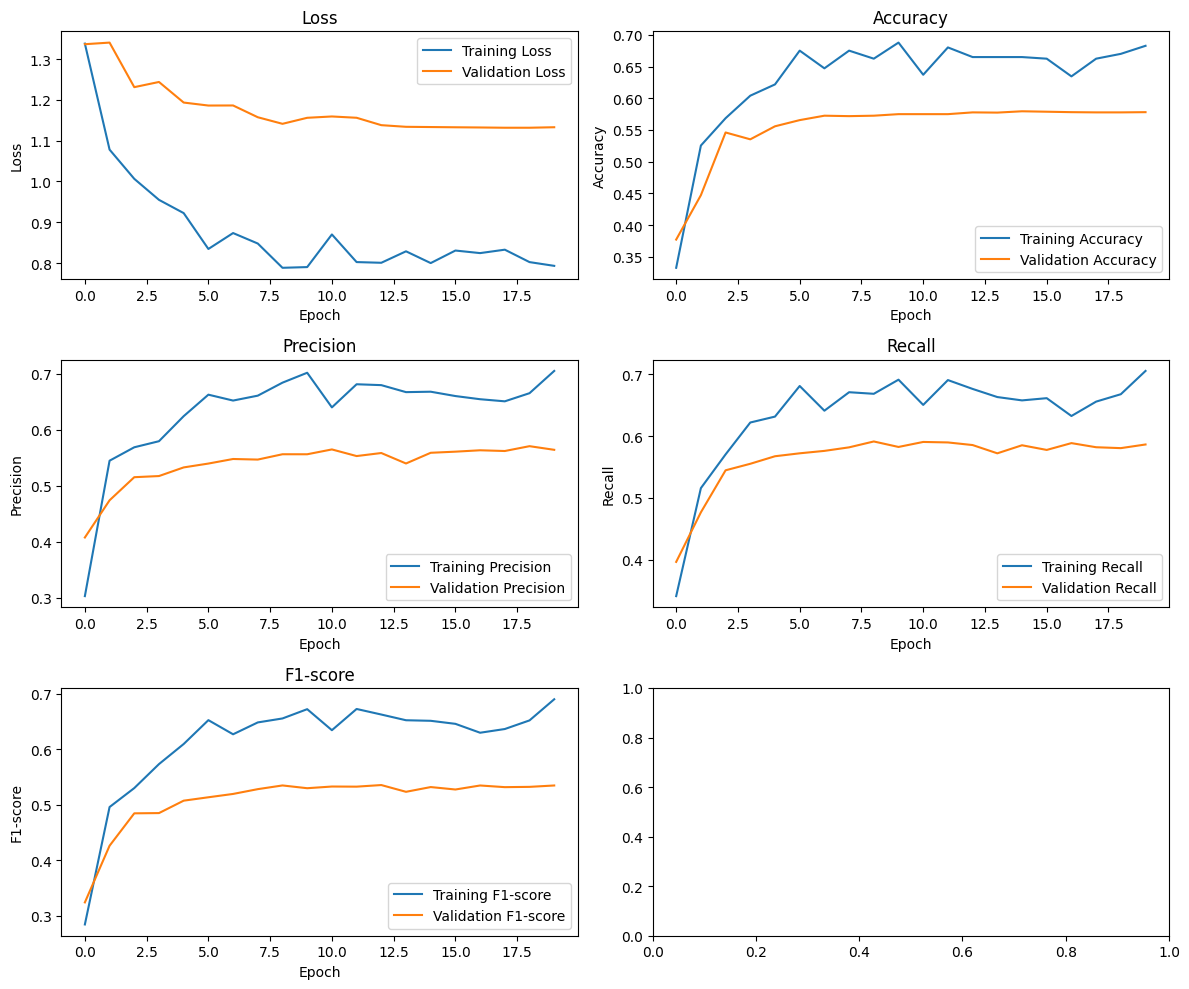

In [43]:
# Example usage (assuming you have the training history)
plot_training_results(vgg_history)

Here's a breakdown of the plots and key observations:

- **Loss**: The training loss (blue line) starts high around 1.3 and steadily decreases over epochs, reaching around 0.75 by epoch 19. This indicates the model is progressively learning to minimize the loss function on the training data.
The validation loss (gorange line) also shows a decreasing trend, though with more fluctuations compared to training loss. It reaches its lowest point around epoch 12 and slightly increases afterward. This suggests the model is generalizing reasonably well to unseen validation data but might be at risk of overfitting in later epochs.

- **Accuracy**: The training accuracy starts around 0.3 and significantly increases to nearly 0.7 by epoch 19. This indicates the model is learning to correctly classify examples in the training data.
The validation accuracy also increases over epochs, reaching a peak of around 0.58 at epoch 3 and fluctuating slightly afterward. This suggests the model can generalize somewhat well to unseen data.

- **Precision, Recall, and F1-Score**: These metrics generally follow similar trends as accuracy, with increasing values over epochs for training and some fluctuations for validation.

- **Early Stopping**: The training process terminates at epoch 19 due to early stopping. This technique helps prevent overfitting by stopping training when the validation loss fails to improve for a certain number of epochs.

- **Overall Interpretation**: The plots suggest that the VGG model successfully learned from the training data, achieving good training accuracy and reasonable validation accuracy. However, the slight increase in validation loss after epoch 12 indicates potential overfitting. Early stopping helps mitigate this issue.

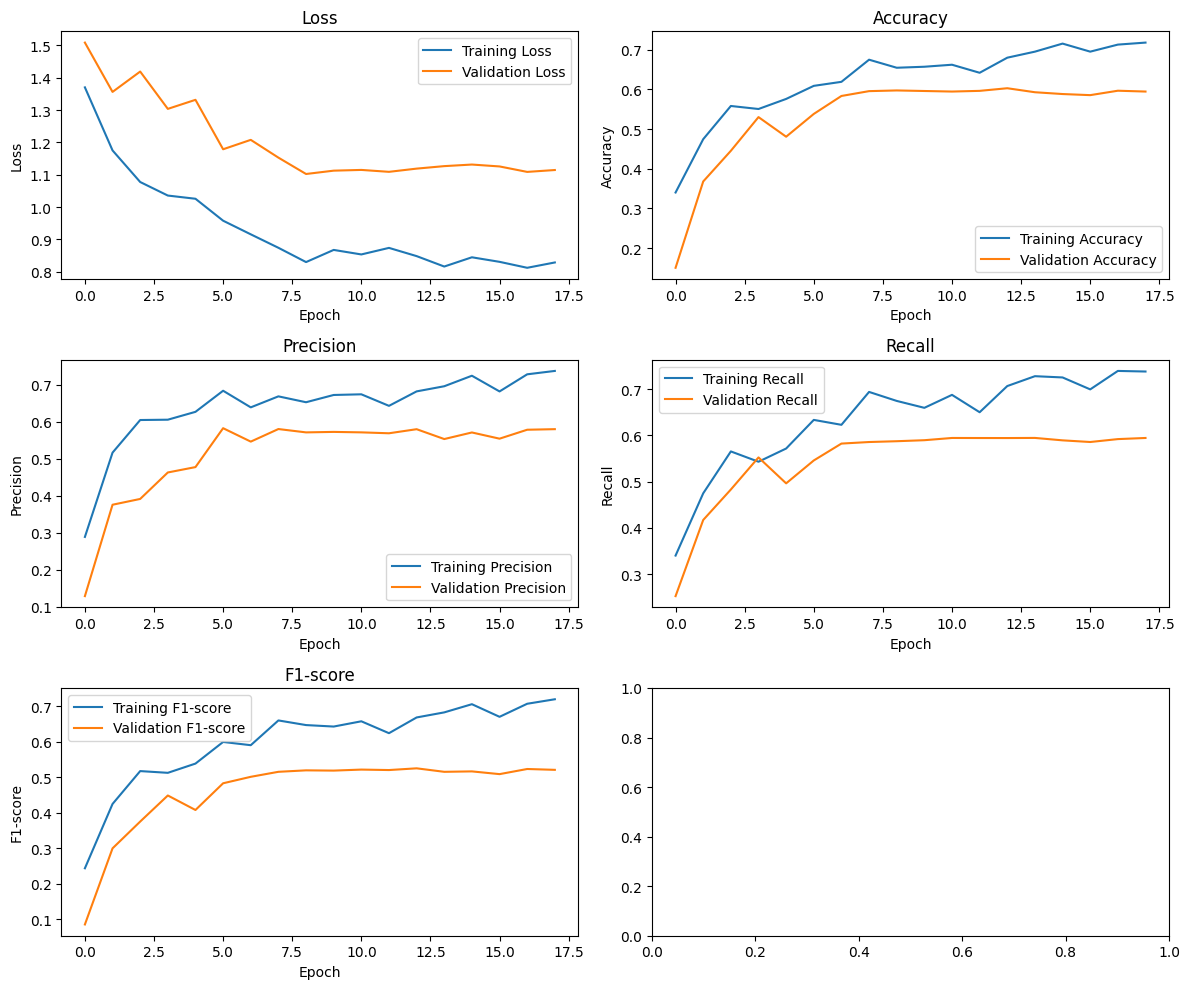

In [44]:
plot_training_results(resnet_history)

- **Loss**: The training loss starts high around 1.3 and steadily decreases over epochs, reaching around 0.8 by epoch 17. This indicates the model is progressively learning to minimize the loss function on the training data.
The validation loss also shows a decreasing trend, though with more fluctuations compared to training loss. It reaches its lowest point around epoch 6 and slightly increases afterward. This suggests the model is generalizing reasonably well to unseen validation data but might be at risk of overfitting in later epochs. Early stopping helps prevent this by stopping training at epoch 17.

- **Accuracy**: The training accuracy starts around 0.3 and significantly increases to nearly 0.7 by epoch 17. This indicates the model is learning to correctly classify examples in the training data.
The validation accuracy also increases over epochs, reaching a peak of around 0.6 at epoch 15 and fluctuating slightly afterward. This suggests the model can generalize somewhat well to unseen data.

- **Precision, Recall, and F1-Score**: These metrics generally follow similar trends as accuracy, with increasing values over epochs for training and some fluctuations for validation.

- **Overall Interpretation**: The plots suggest that the ResNet model successfully learned from the training data, achieving good training accuracy and reasonable validation accuracy. However, the slight increase in validation loss after epoch 6 indicates potential overfitting. Early stopping helps mitigate this issue.

**Comparing to VGG**

ResNet appears to have achieved better validation accuracy (around 0.7) compared to VGG (around 0.58) based on the peaks of their validation accuracy curves.
ResNet's training loss seems to have plateaued at a slightly higher value than VGG's, potentially indicating slightly less optimal learning, but this could be due to factors like different learning rates used in training.

**Implications**

ResNet might be a better choice than VGG for this task due to its slightly superior validation accuracy, suggesting better generalization potential.
